# Exploratory Data Analysis

In [1]:
#Mount Drive if running in Colab
from sys import path
import os

if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  root_PATH = '/content/drive/My Drive/nlp-seminar/repository'
  drive_mount_location = '/content/drive'

  drive.mount(drive_mount_location, force_remount=True)
  path.append(root_PATH)
else:
  root_PATH = os.path.abspath("..")
  

## Prepare Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_location = root_PATH + '/data/data.csv'

In [4]:
data_df = pd.read_csv(data_location)
%store data_df

Stored 'data_df' (DataFrame)


In [5]:
%store -r data_df

In [6]:
#Convert the topics into a list
data_df["Topic"] = data_df["Topic"].apply(eval)

In [7]:
#Convert lists into Pandas series so they can be analized
def list_to_series(series):
 return pd.Series([x for _list in series for x in _list])

## Counts per topic

In [8]:
topic_counts = list_to_series(data_df["Topic"]).value_counts()
topic_counts.to_excel(root_PATH + '/data/topic-counts.xlsx')
topic_counts

Satisfied users           309161
Bugs                      117622
Design & UX                93069
Dissatisfied users         74313
Performance                56406
Use cases                  53235
Gaming                     45754
Feature Requests           42852
Complexity                 37849
Pricing                    28710
Security & Accounts        28584
Update                     28536
Camera & Photos            28372
Video                      27116
Customer Support           25900
Notifications & Alerts     24644
Frequency                  21840
Advertising                20442
Payment                    19004
Connectivity               18916
Devices                    16859
Audio                      16323
Sign Up & Login            12617
Location Services           7617
Privacy                     5288
Internationalization        4497
Streaming                   3378
Social & Collaboration      1953
Import Export                904
Battery                      661
HDMI      

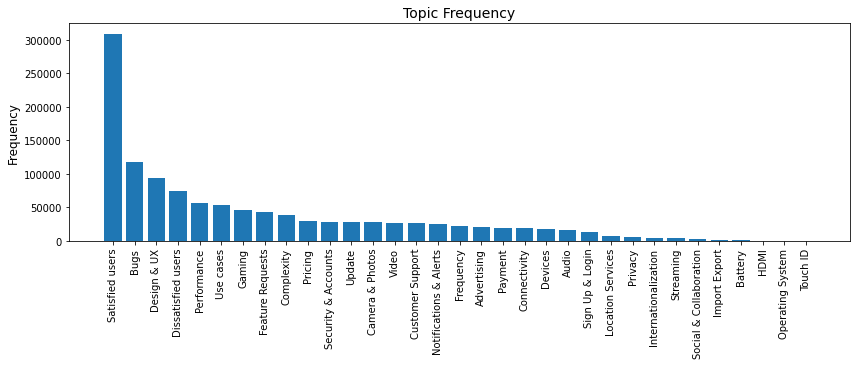

In [9]:
fig, ax = plt.subplots(figsize = (14,4))
ax.bar(list_to_series(data_df["Topic"]).value_counts().index,
        list_to_series(data_df["Topic"]).value_counts().values)
ax.set_ylabel("Frequency", size = 12)
ax.set_title("Topic Frequency", size = 14)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

## Sentiment Distribution

<AxesSubplot:xlabel='Sentiment'>

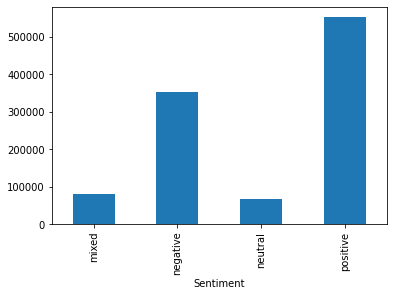

In [10]:
sentiment_distribution = data_df.groupby(['Sentiment']).size()

sentiment_distribution.plot.bar()

## Exploring relationships between sentiment and topic

In [12]:
def boolean_df(item_lists, unique_items):# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [13]:
unique_items_topics = list_to_series(data_df["Topic"]).value_counts().index.tolist()
unique_items_sentiment = data_df["Sentiment"].unique()

data_bool_topics = boolean_df(data_df["Topic"],unique_items_topics)
data_bool_sentiment = boolean_df(data_df["Sentiment"],unique_items_sentiment)

complete_data_bool = data_bool_topics.join(data_bool_sentiment)
complete_data_int = complete_data_bool.astype(int)

In [14]:
freq_mat = np.dot(complete_data_int.T, complete_data_int)

In [15]:
freq = pd.DataFrame(freq_mat, columns = complete_data_int.columns.tolist(), index = complete_data_int.columns.tolist())
sentiment_topic_relationship = freq.drop(data_bool_topics)
sentiment_topic_relationship

Satisfied users   Bugs  Design & UX  Dissatisfied users  \
positive           279071   5384        42361                   0   
mixed               15609  13612         5520                 102   
negative                0  93410        39793               73748   
neutral             14481   5216         5395                 463   

          Performance  Use cases  Gaming  Feature Requests  Complexity  \
positive        11118      34528   21459              8263       29223   
mixed            5056       2602    3775              5387        1234   
negative        37119      12055   16900             24107        5536   
neutral          3113       4050    3620              5095        1856   

          Pricing  ...  Social & Collaboration  Import Export  Battery  HDMI  \
positive     5745  ...                     880            155       41    17   
mixed        1904  ...                     195             89       57    10   
negative    19133  ...                     617            569      522    72   
neutral      1928  ...                     261             91       41    11   

          Operating System  Touch ID  positive  mixed  negative  neutral  
positive                 2        11    552195      0         0        0  
mixed                    8         8         0  79193         0        0  
negative                86        46         0      0    350812        0  
neutral                  8         8         0      0         0    66375  

[4 rows x 37 columns]

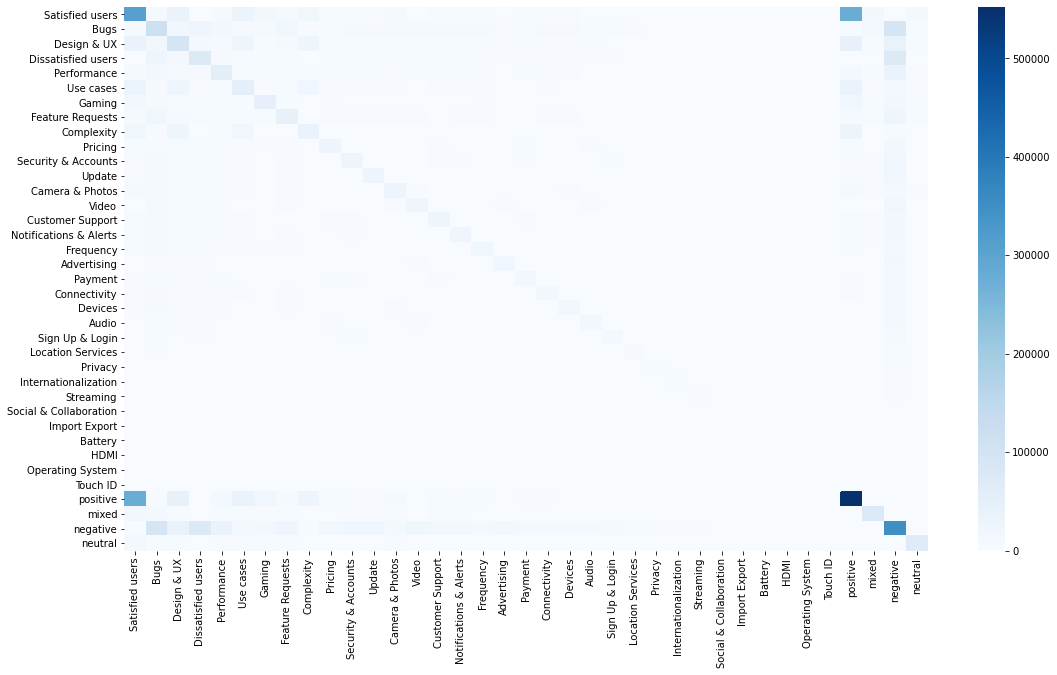

In [16]:
import seaborn as sn

fig, ax = plt.subplots(figsize = (18,10))
sn.heatmap(freq, cmap = "Blues")
plt.xticks(rotation=90)
plt.show()

In [18]:
#Normalized heatmap
#TODO: how to plot a normalized heatmap?

## Further Data Exploration

### Rows with no topic

In [17]:
complete_data_int_no_sentiment = complete_data_int.iloc[:,:-4]
rows_with_no_topic = complete_data_int_no_sentiment[(complete_data_int_no_sentiment==0).all(axis=1)]

print(rows_with_no_topic.shape[0])
print(data_df.shape[0])

412995
1048575


### Exploring topics with multiple labels

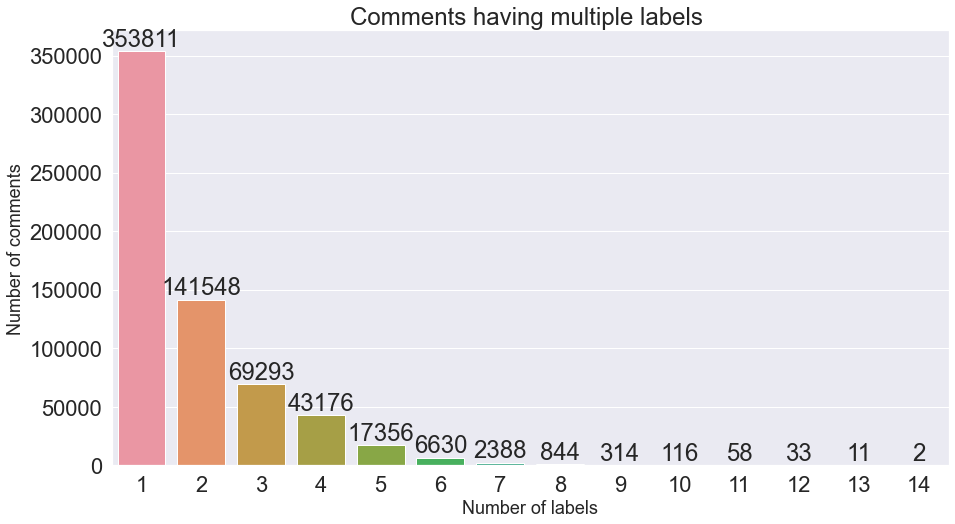

In [20]:
#Number of topics per comment

row_sums = complete_data_int.iloc[:,:-4].sum(axis=1)
multiLabel_counts = row_sums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sn.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sn.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

### Dataset wordclouds

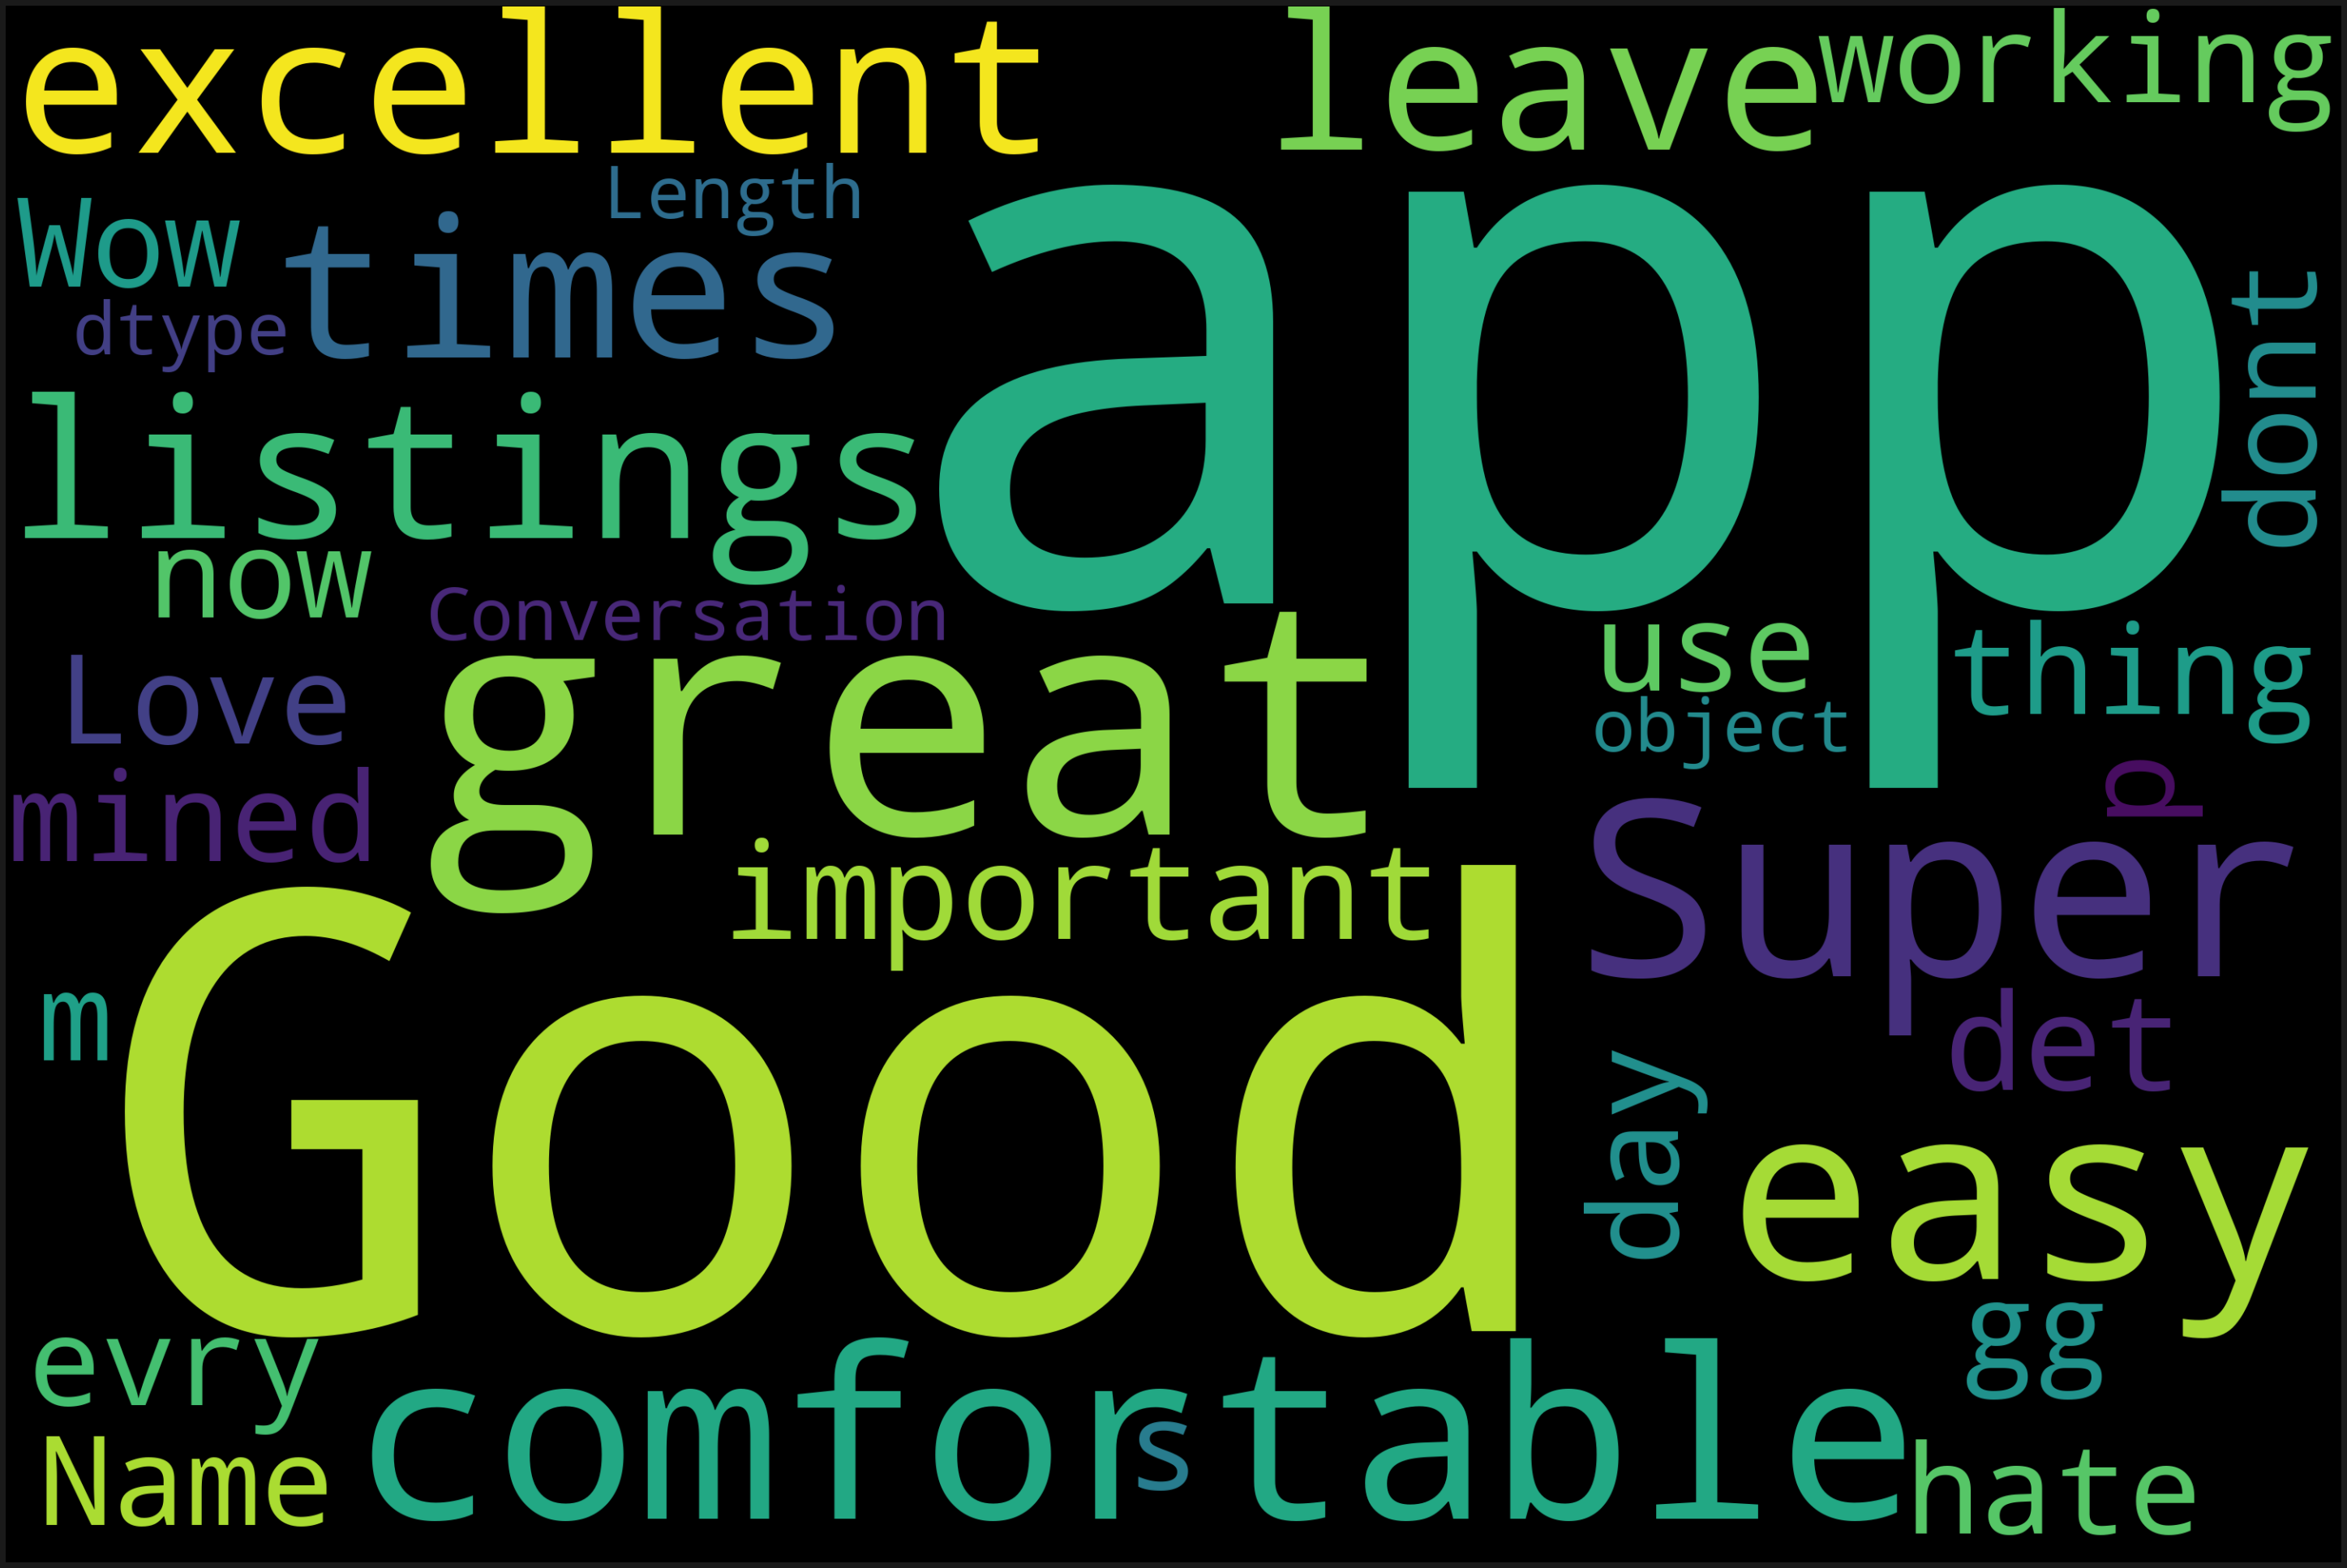

In [21]:
#Wordcloud of the complete dataset
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = data_df.Conversation
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')


plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [22]:
#Why does the word cloud contain single-letter or two-letter words? (m,p,s,gg)
def contains_word(s, w):
    return (' ' + w + ' ') in (' ' + s + ' ')

word_to_search = "gg"
rows_containing_word = data_df[data_df.apply(lambda row: contains_word(str(row["Conversation"]), word_to_search), axis=1)]

#g = mostly errors and data noise
#g = mostly errors and data noise
#m = mostly errors and people trying to use the I'm contraction, but writing I m
#s = mostly errors and people trying to use the It's contraction, but writing It s
#gg = common expression for gamers.

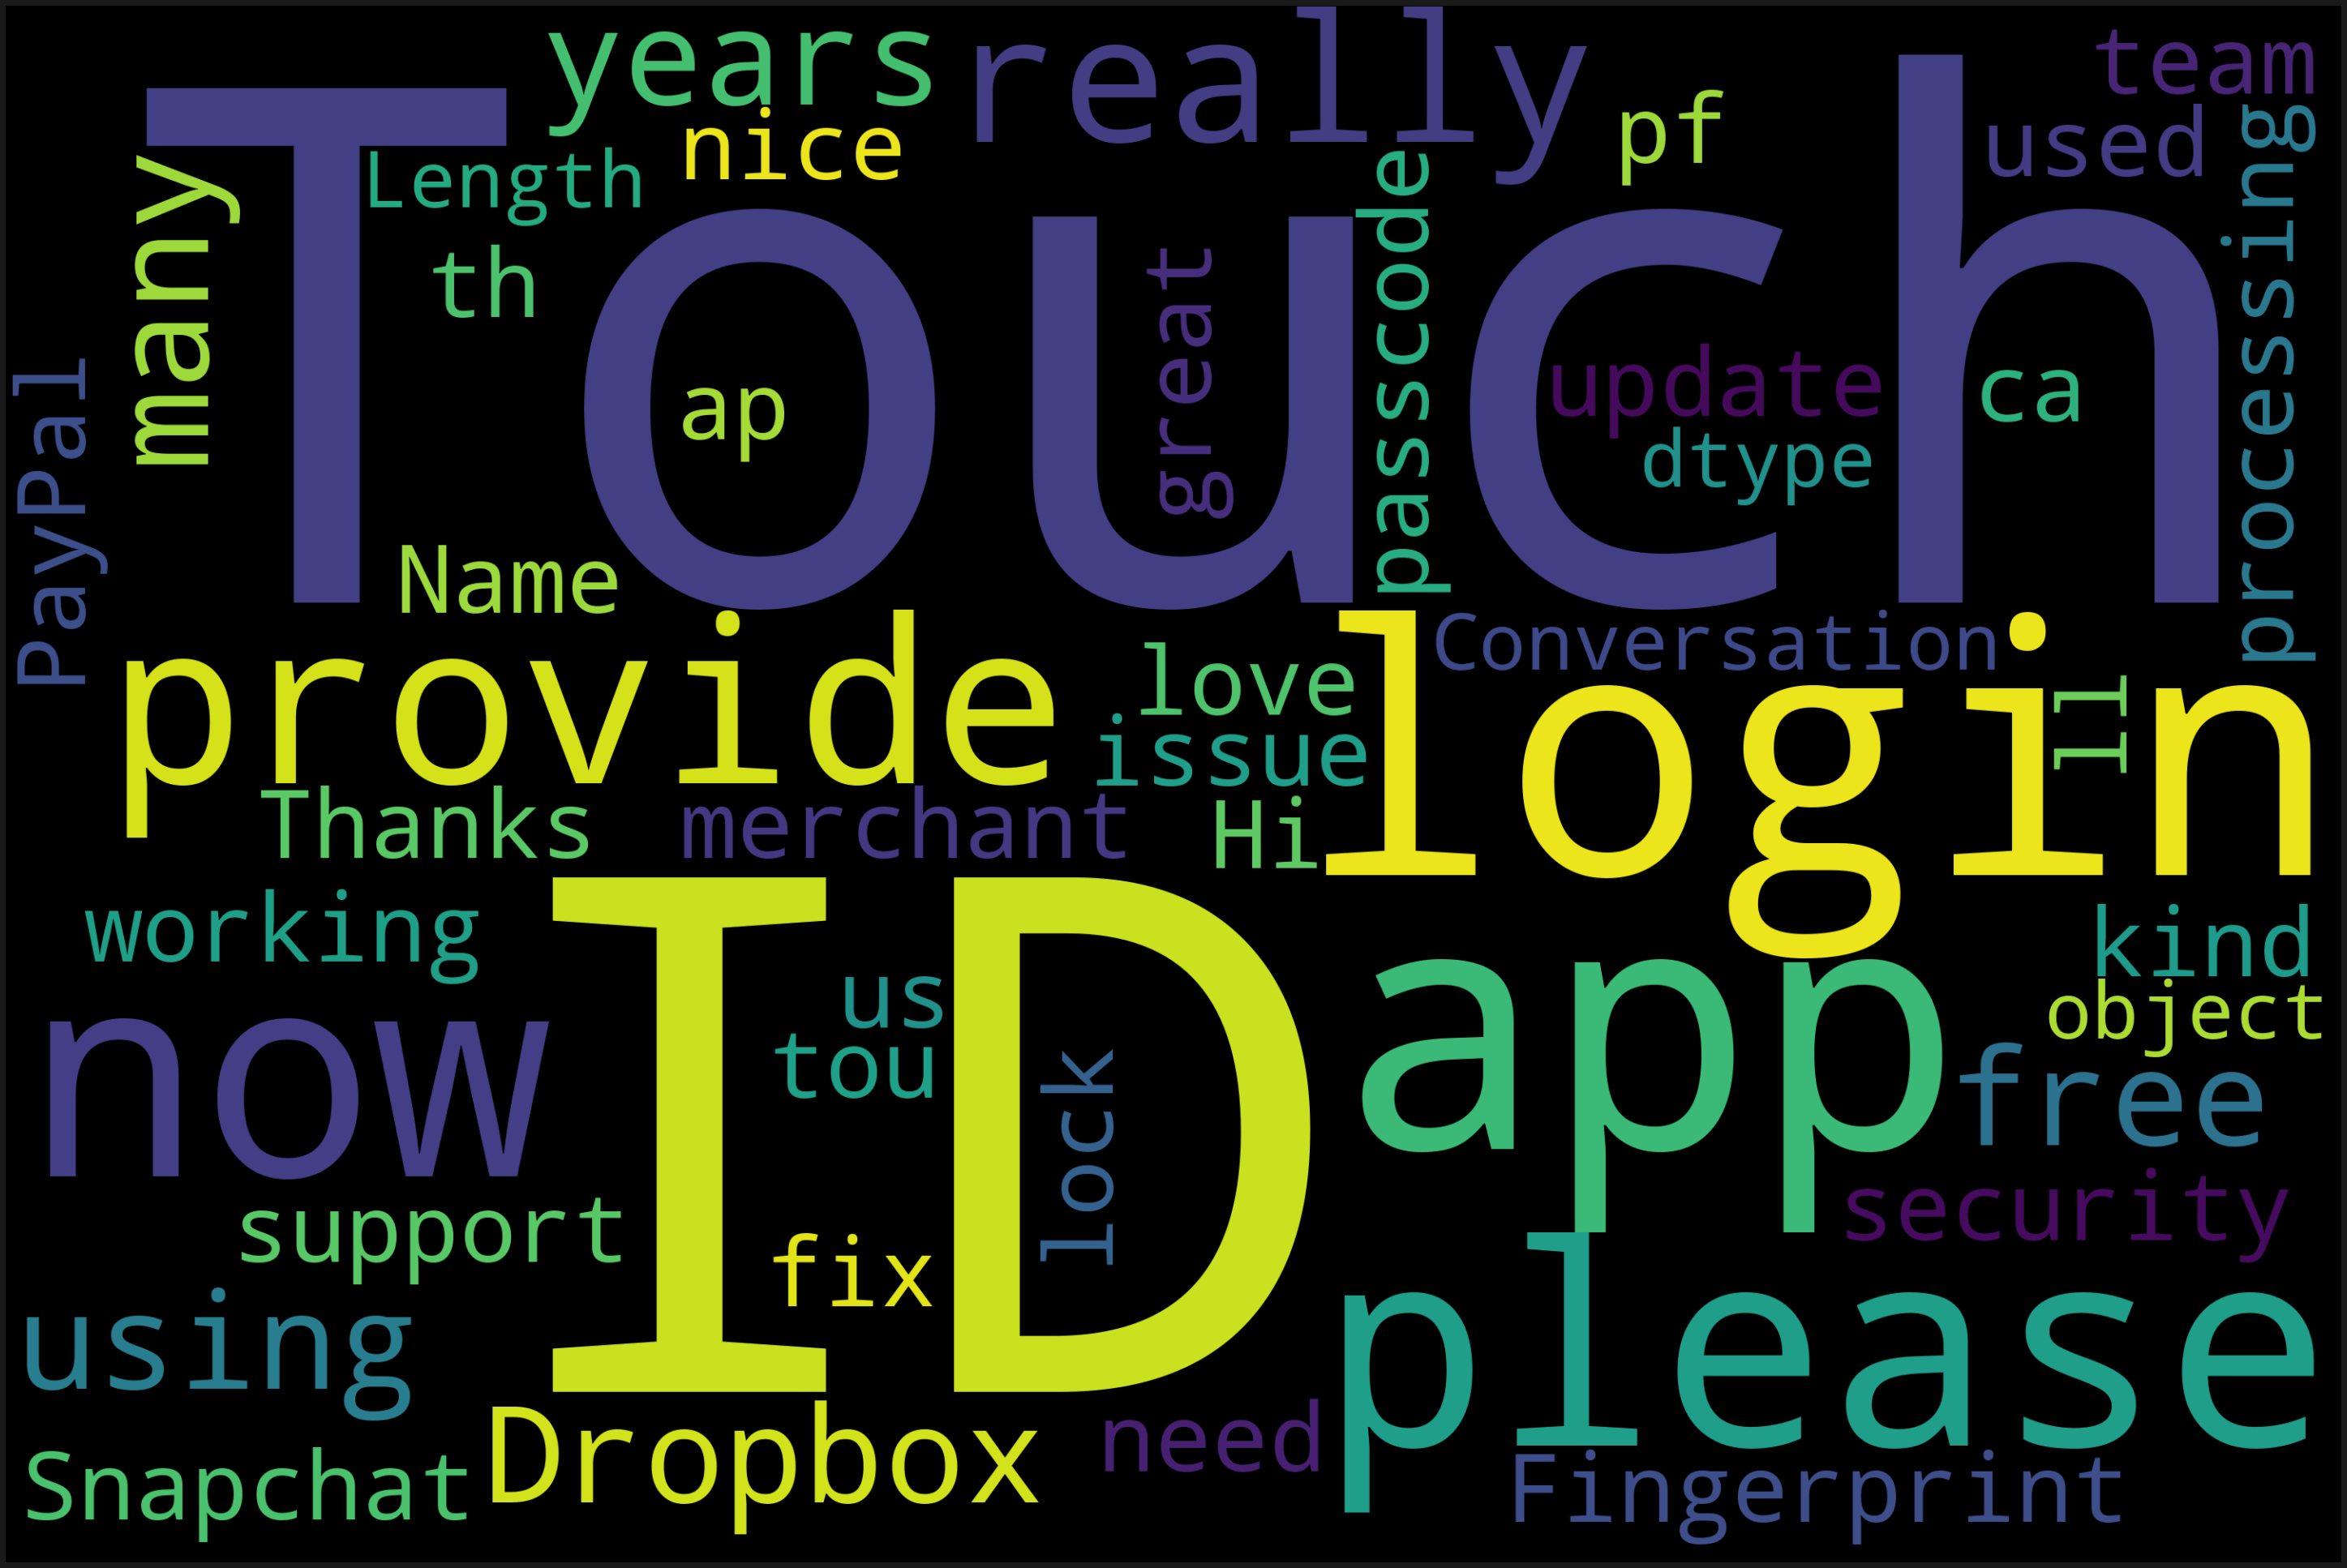

In [23]:
#Wordcloud of the category Touch ID (one of the underrepresented categories, which achieved a great accuracy with a simple Naive Bayes baseline)
topic = "Touch ID"
complete_data_df = data_df.join(complete_data_int)

data_containing_topic = complete_data_df.loc[complete_data_df[topic] == 1]

text = data_containing_topic.Conversation
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [24]:
import nltk

#Uncomment to calculate the number of tokens. To load the precalculated file, run the following cell

#Count number of tokens
#data_df['Tokens'] = data_df.apply (lambda row: len(nltk.word_tokenize(str(row["Conversation"]))), axis=1)
#counts = data_df['Tokens'].value_counts()

#data_df.to_csv(root_PATH + 'data-with-tokens.csv')


### Analyzing the number of topics of our dataset

In [24]:
data_df = pd.read_csv(root_PATH + 'data-with-tokens.csv')

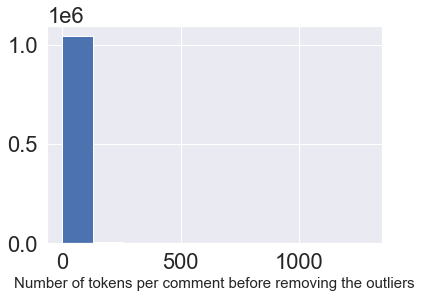

In [26]:
#Number of tokens per sentence
tokens_per_sentence_plot = data_df["Tokens"].hist()
tokens_per_sentence_plot.set_xlabel("Number of tokens per comment before removing the outliers",fontsize=15)
plt.show()

#There are clearly some outliers

In [27]:
#Comments with many tokens
values_to_evaluate = [700,512,200,100,50,30,25,20,10]

for limit in values_to_evaluate:
    number_of_sentences = data_df[data_df["Tokens"].apply(lambda x: x > limit)].shape[0]
    print(f"comments with more than {limit} tokens: {number_of_sentences}, {number_of_sentences/data_df.shape[0]} %")

#82% of our dataset has less than 25 tokens

comments with more than 700 tokens: 46, 4.386906039148368e-05 %
comments with more than 512 tokens: 110, 0.0001049042748492001 %
comments with more than 200 tokens: 2048, 0.0019531268626469256 %
comments with more than 100 tokens: 17434, 0.016626373888372317 %
comments with more than 50 tokens: 80079, 0.07636935841499178 %
comments with more than 30 tokens: 162143, 0.15463176215339866 %
comments with more than 25 tokens: 197116, 0.18798464582886298 %
comments with more than 20 tokens: 242537, 0.2313015282645495 %
comments with more than 10 tokens: 392232, 0.37406194120592234 %


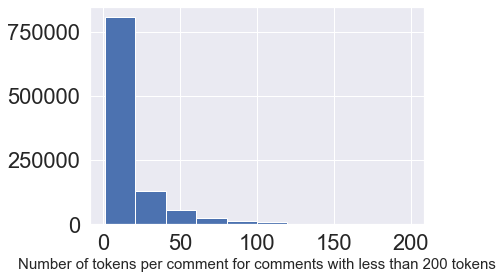

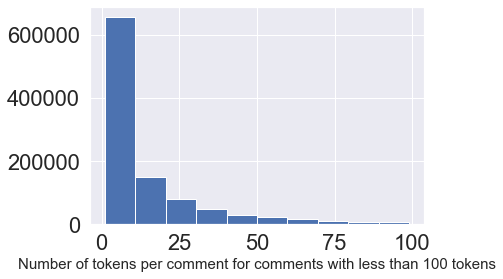

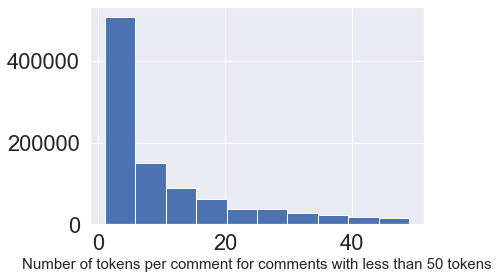

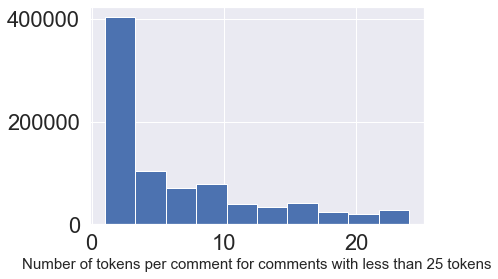

In [28]:
#Barplots without outliers (removing all with more than 200 tokens)
values_to_plot = [200,100,50,25]

for limit in values_to_plot:
    data_df_without_outliers = data_df[data_df["Tokens"].apply(lambda x: x < limit)]
    tokens_per_sentence_plot = data_df_without_outliers["Tokens"].hist()
    tokens_per_sentence_plot.set_xlabel(f"Number of tokens per comment for comments with less than {limit} tokens",fontsize=15)
    plt.show()

#We have a lot of short comments

In [29]:
#Comments with few tokens
values_to_evaluate = [1,2,3,4,5]

for value in values_to_evaluate:
    number_of_sentences = data_df[data_df["Tokens"].apply(lambda x: x == value)].shape[0]
    print(f"comments with {value} tokens: {number_of_sentences}, {number_of_sentences/data_df.shape[0]} %")

#19% of the data has only one token
#37% of the comments have 3 or less tokens!

comments with 1 tokens: 203125, 0.19371528026130702 %
comments with 2 tokens: 121954, 0.11630450849963045 %
comments with 3 tokens: 78544, 0.07490546694323248 %
comments with 4 tokens: 57135, 0.05448823403190044 %
comments with 5 tokens: 46284, 0.0441399041556398 %


In [71]:
#How many short sentences do actually contain a topic?

complete_data_df = data_df.join(complete_data_int)

rows_with_one_token_df = complete_data_df[complete_data_df["Tokens"].apply(lambda x: x == 1)]
rows_with_two_tokens_df = complete_data_df[complete_data_df["Tokens"].apply(lambda x: x == 2)]
rows_with_three_tokens_df = complete_data_df[complete_data_df["Tokens"].apply(lambda x: x == 3)]

dataframes = [rows_with_one_token_df,rows_with_two_tokens_df,rows_with_three_tokens_df]

for dataframe in dataframes:
    complete_data = dataframe.iloc[:,10:-4]
    rows_with_no_topic = complete_data[(complete_data==0).all(axis=1)]
    print(f"from all the comments with this number of topics, ({dataframe.shape[0]}), {dataframe.shape[0]} have no topic. = {rows_with_no_topic.shape[0]/     dataframe.shape[0]}%")


from all the comments with this number of topics, (203125), 203125 have no topic. = 0.774468923076923%
from all the comments with this number of topics, (121954), 121954 have no topic. = 0.4705954704232744%
from all the comments with this number of topics, (78544), 78544 have no topic. = 0.4341770217966999%


In [76]:
#Topic distribution of 1 token comments
#This fails when run more than one time
for dataframe in dataframes:
    dataframe["Topic"] = dataframe["Topic"].apply(eval)

In [79]:
for dataframe in dataframes:
    topic_counts = list_to_series(dataframe["Topic"]).value_counts()
    print(topic_counts)
    print("********")

Satisfied users           40729
Dissatisfied users         2103
Design & UX                1412
Performance                 734
Complexity                  342
Bugs                        305
Video                       159
Advertising                 134
Pricing                     117
Update                       74
Customer Support             71
Camera & Photos              65
Security & Accounts          42
Gaming                       37
Use cases                    36
Privacy                      34
Devices                      30
Feature Requests             26
Connectivity                 17
Internationalization         15
Audio                        14
Notifications & Alerts       11
Payment                      10
Location Services             9
Sign Up & Login               9
Frequency                     9
Streaming                     6
Import Export                 1
Battery                       1
dtype: int64
********
Satisfied users           52910
Dissatisfied users

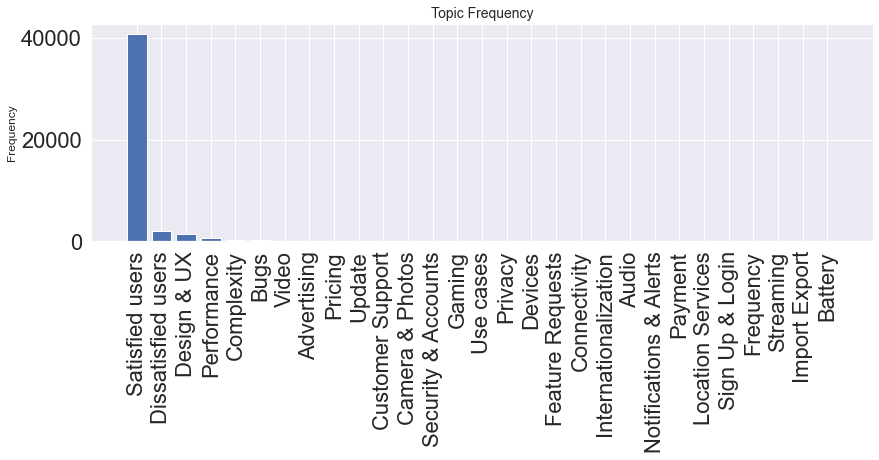

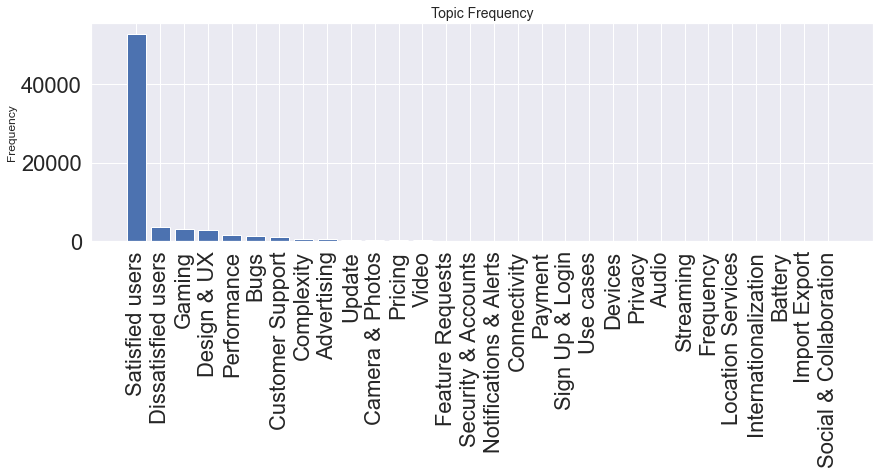

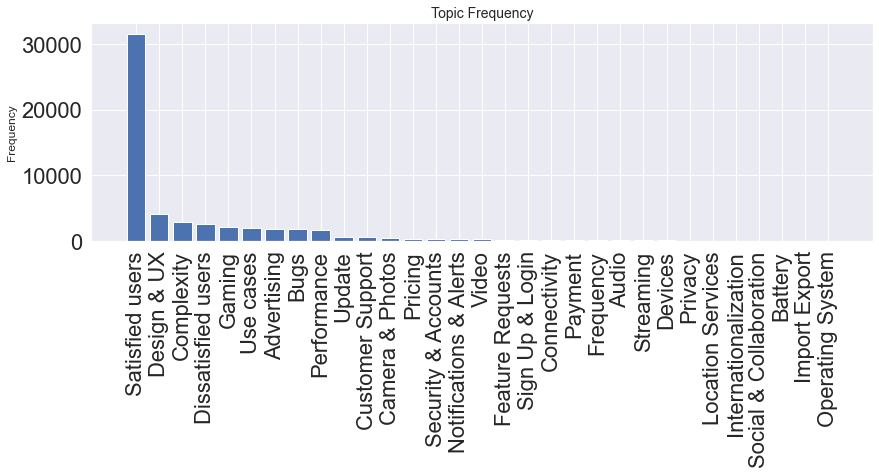

In [80]:

for dataframe in dataframes:
    fig, ax = plt.subplots(figsize = (14,4))
    ax.bar(list_to_series(dataframe["Topic"]).value_counts().index,
            list_to_series(dataframe["Topic"]).value_counts().values)
    ax.set_ylabel("Frequency", size = 12)
    ax.set_title("Topic Frequency", size = 14)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

#most of the 1 token comments that have a topic, have the topic: satsfied users, dissatisfied users or design and ux
#A lot of short sentences have no topic, but when they have, they usually have the same topics

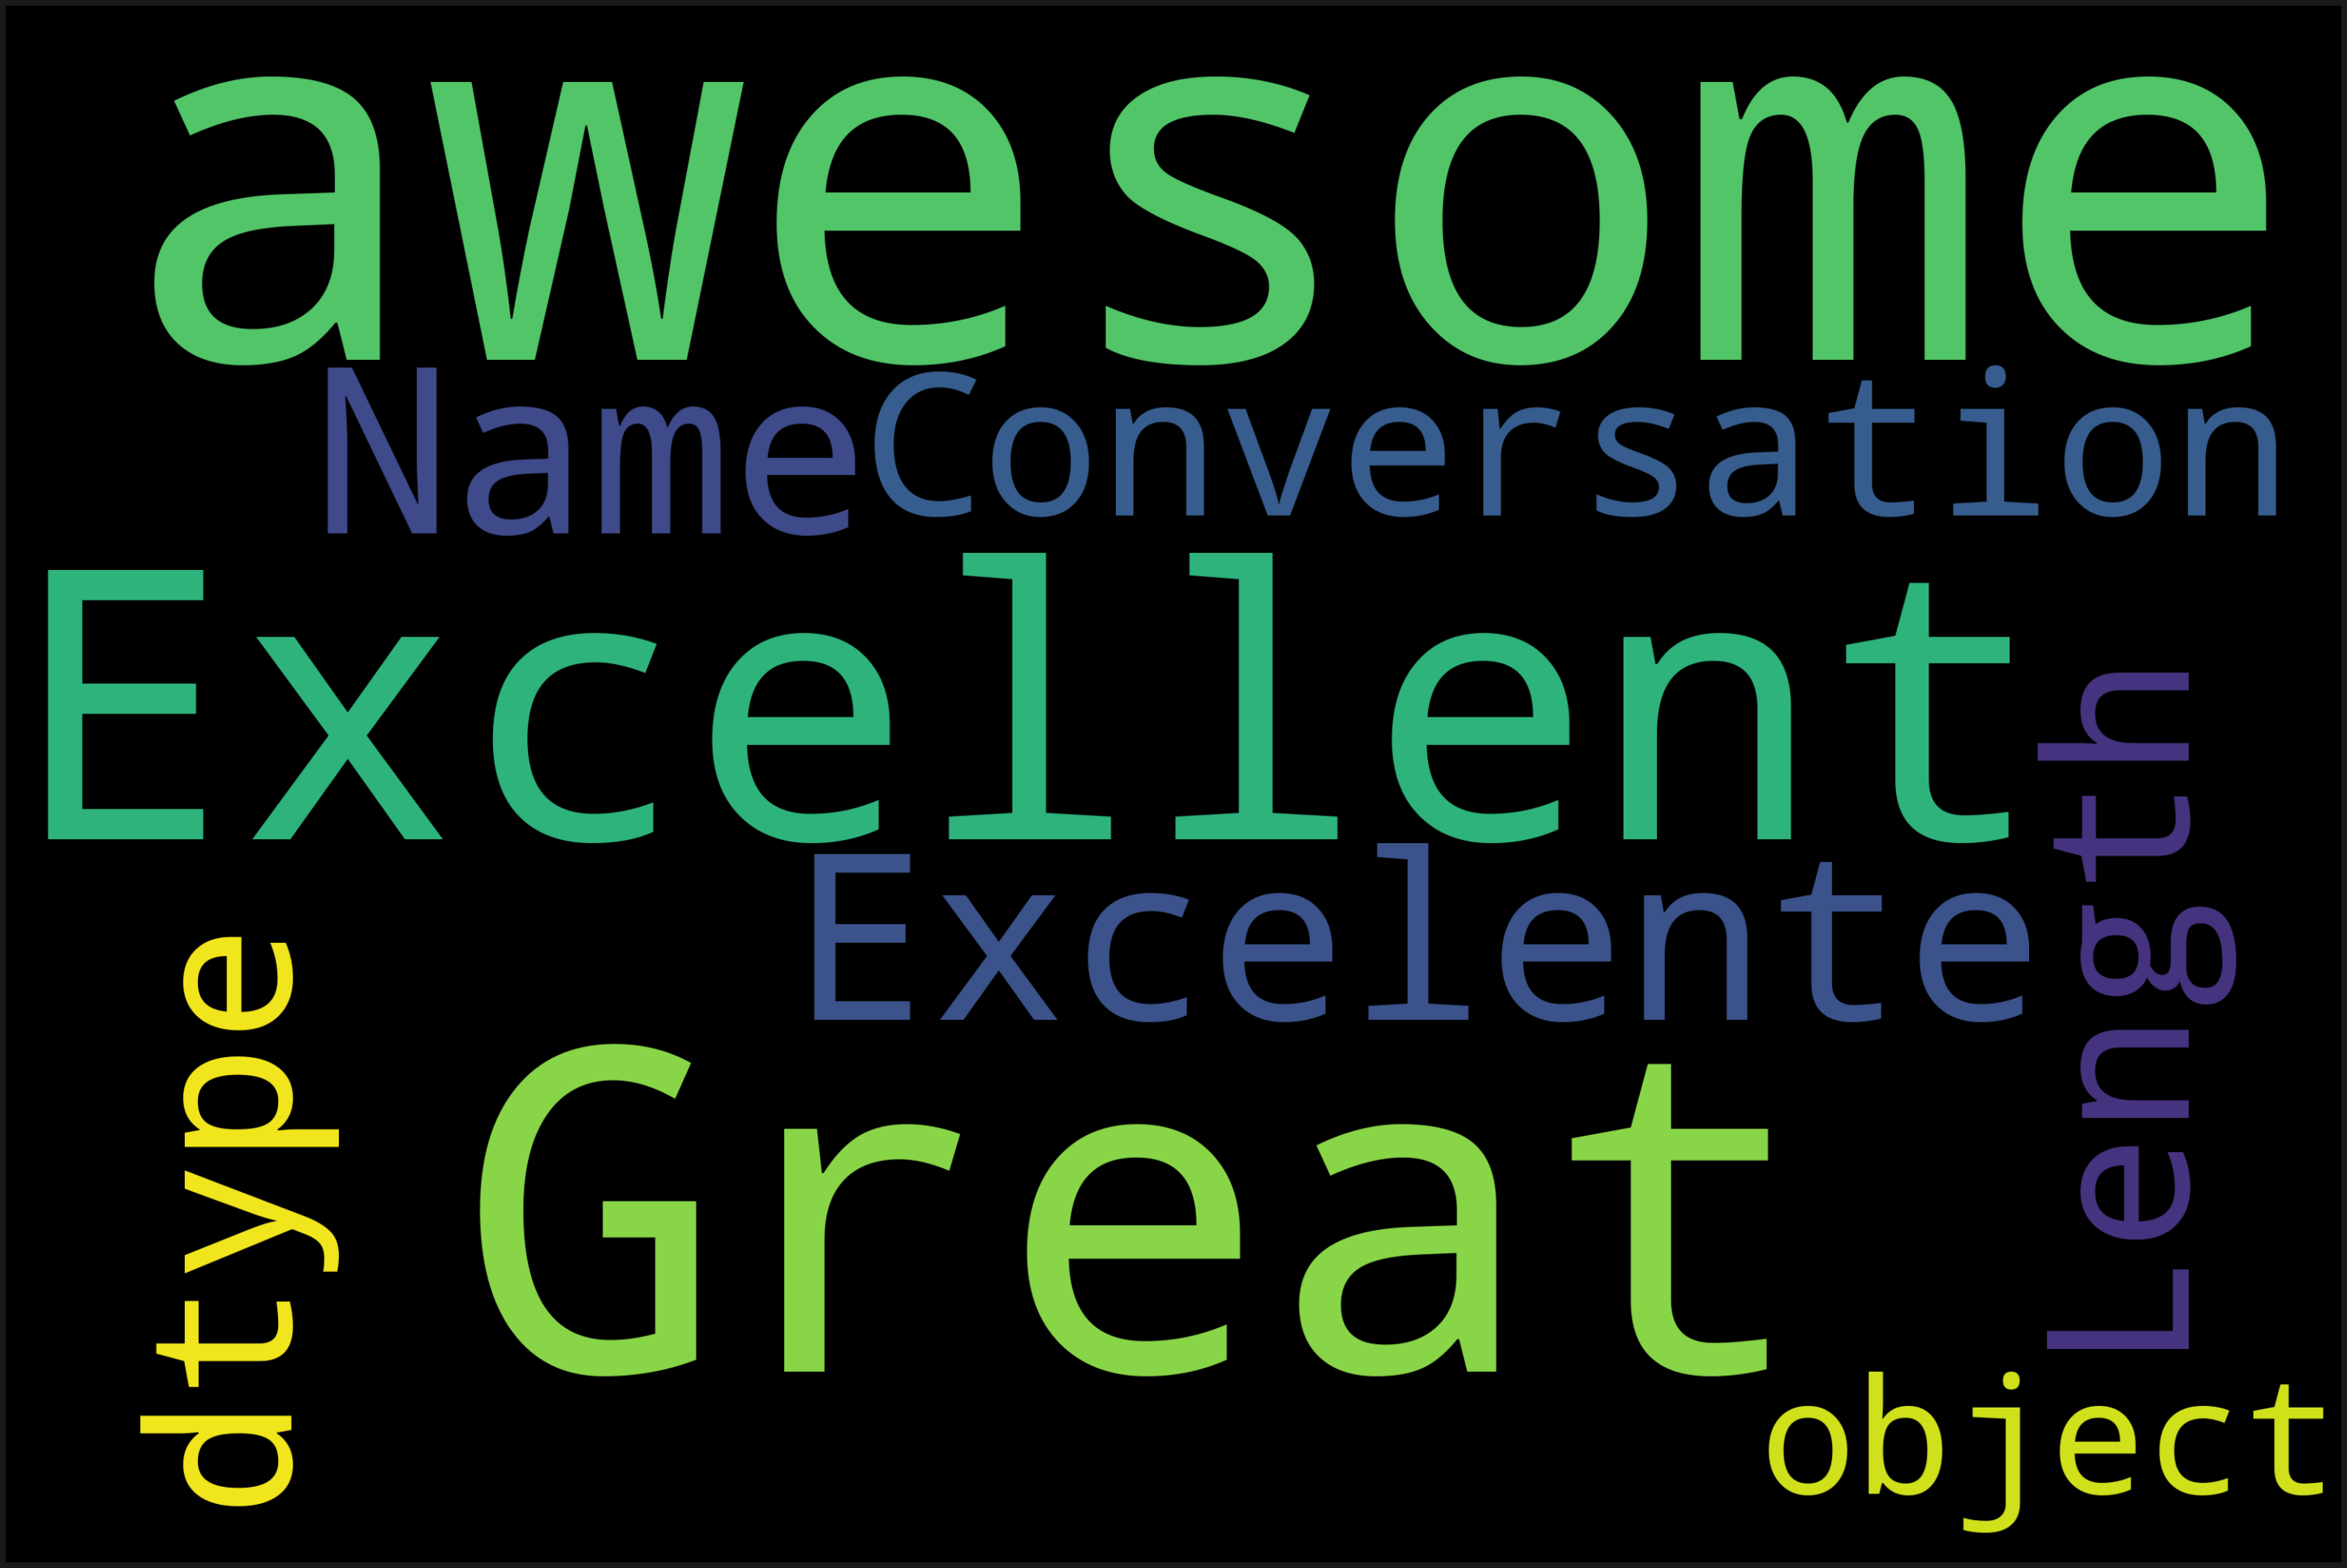

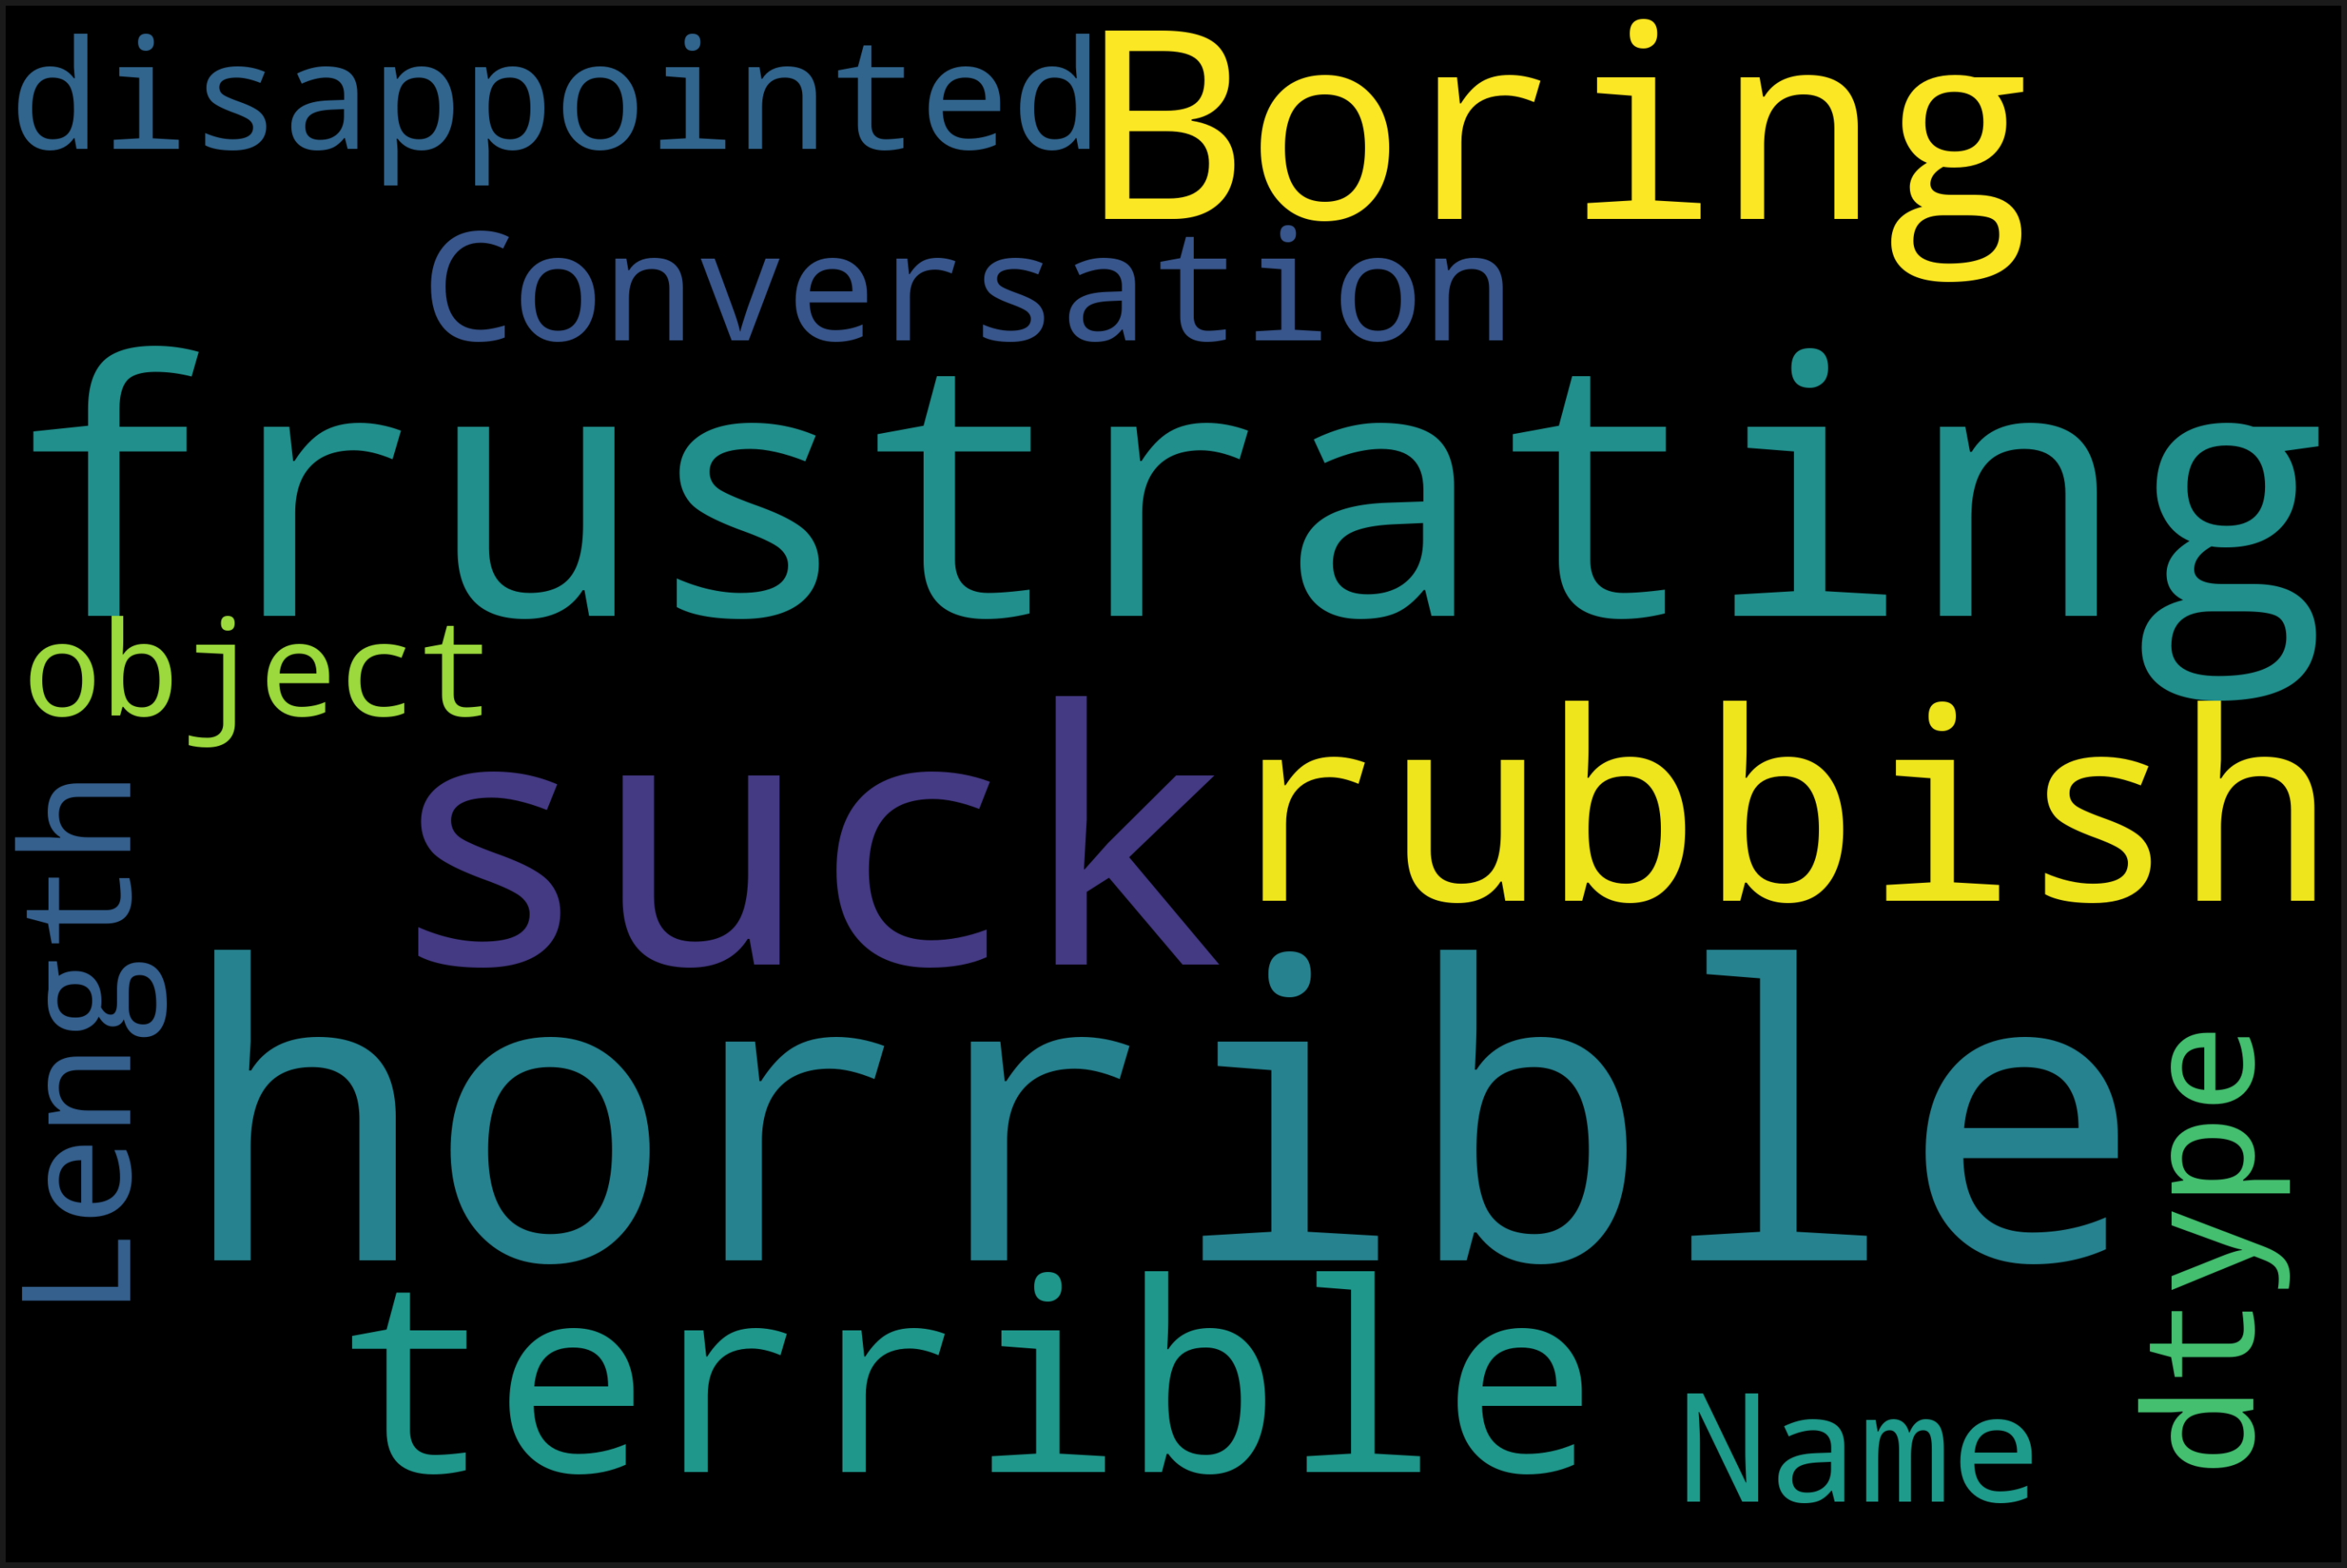

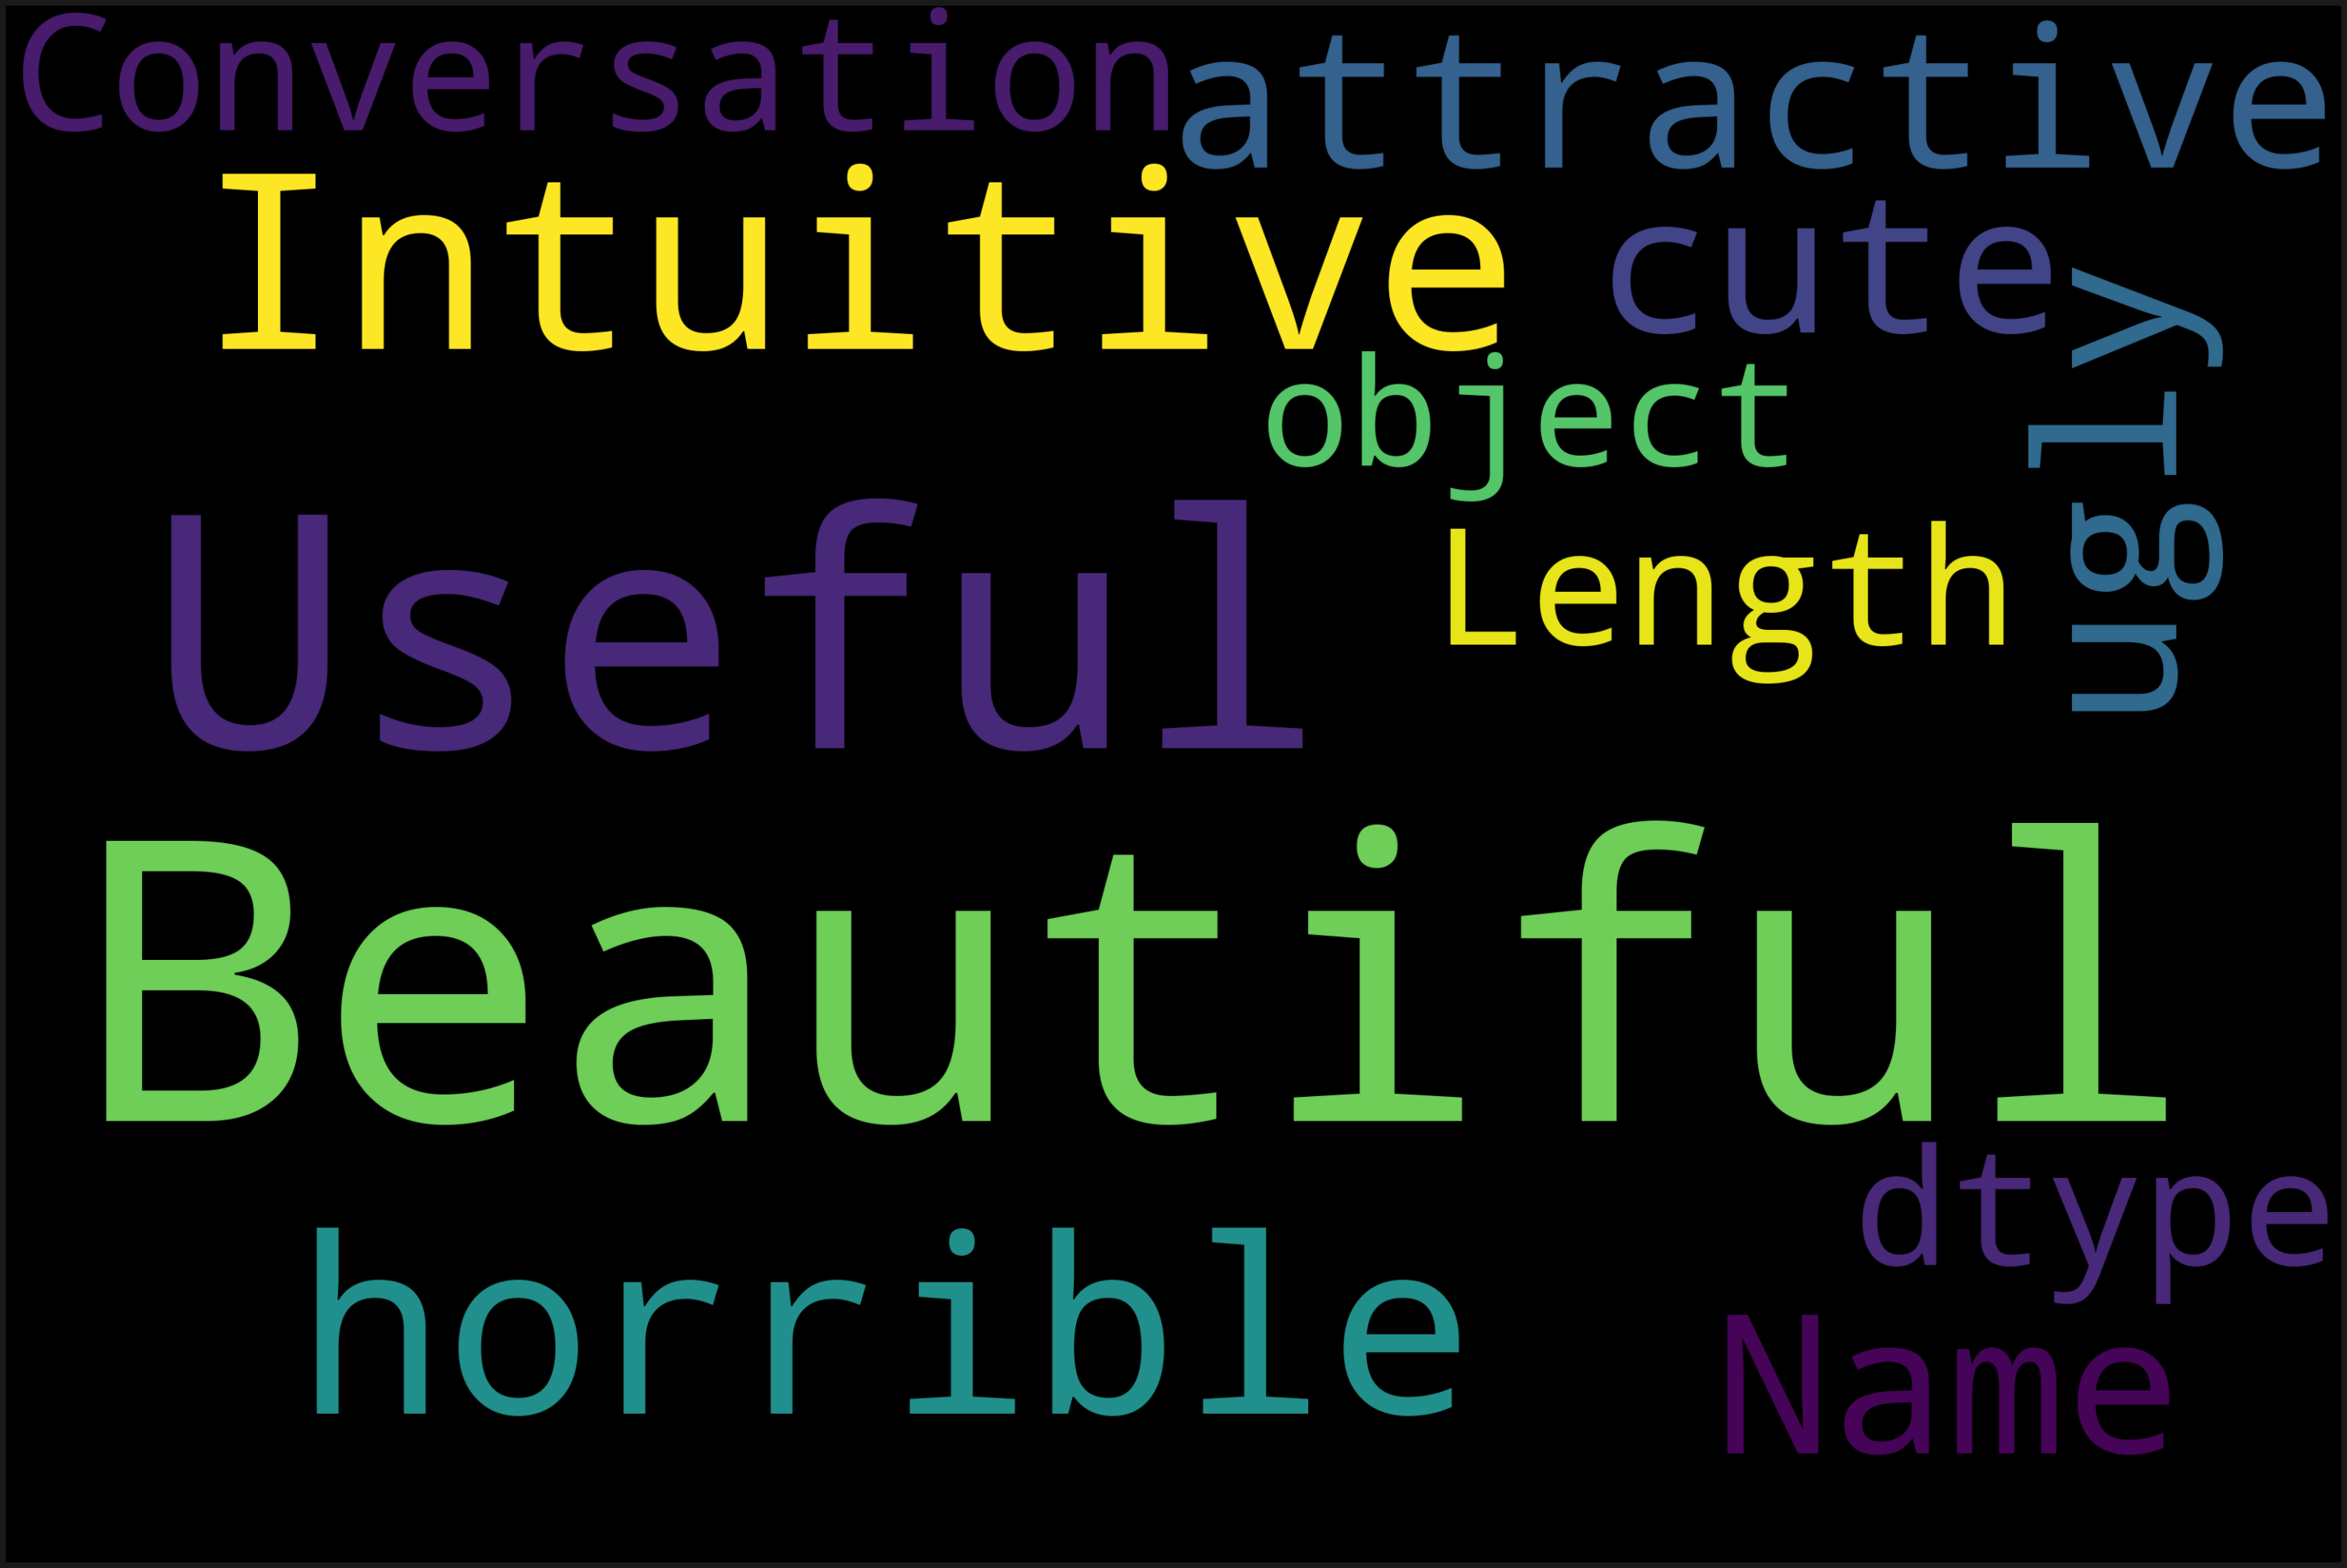

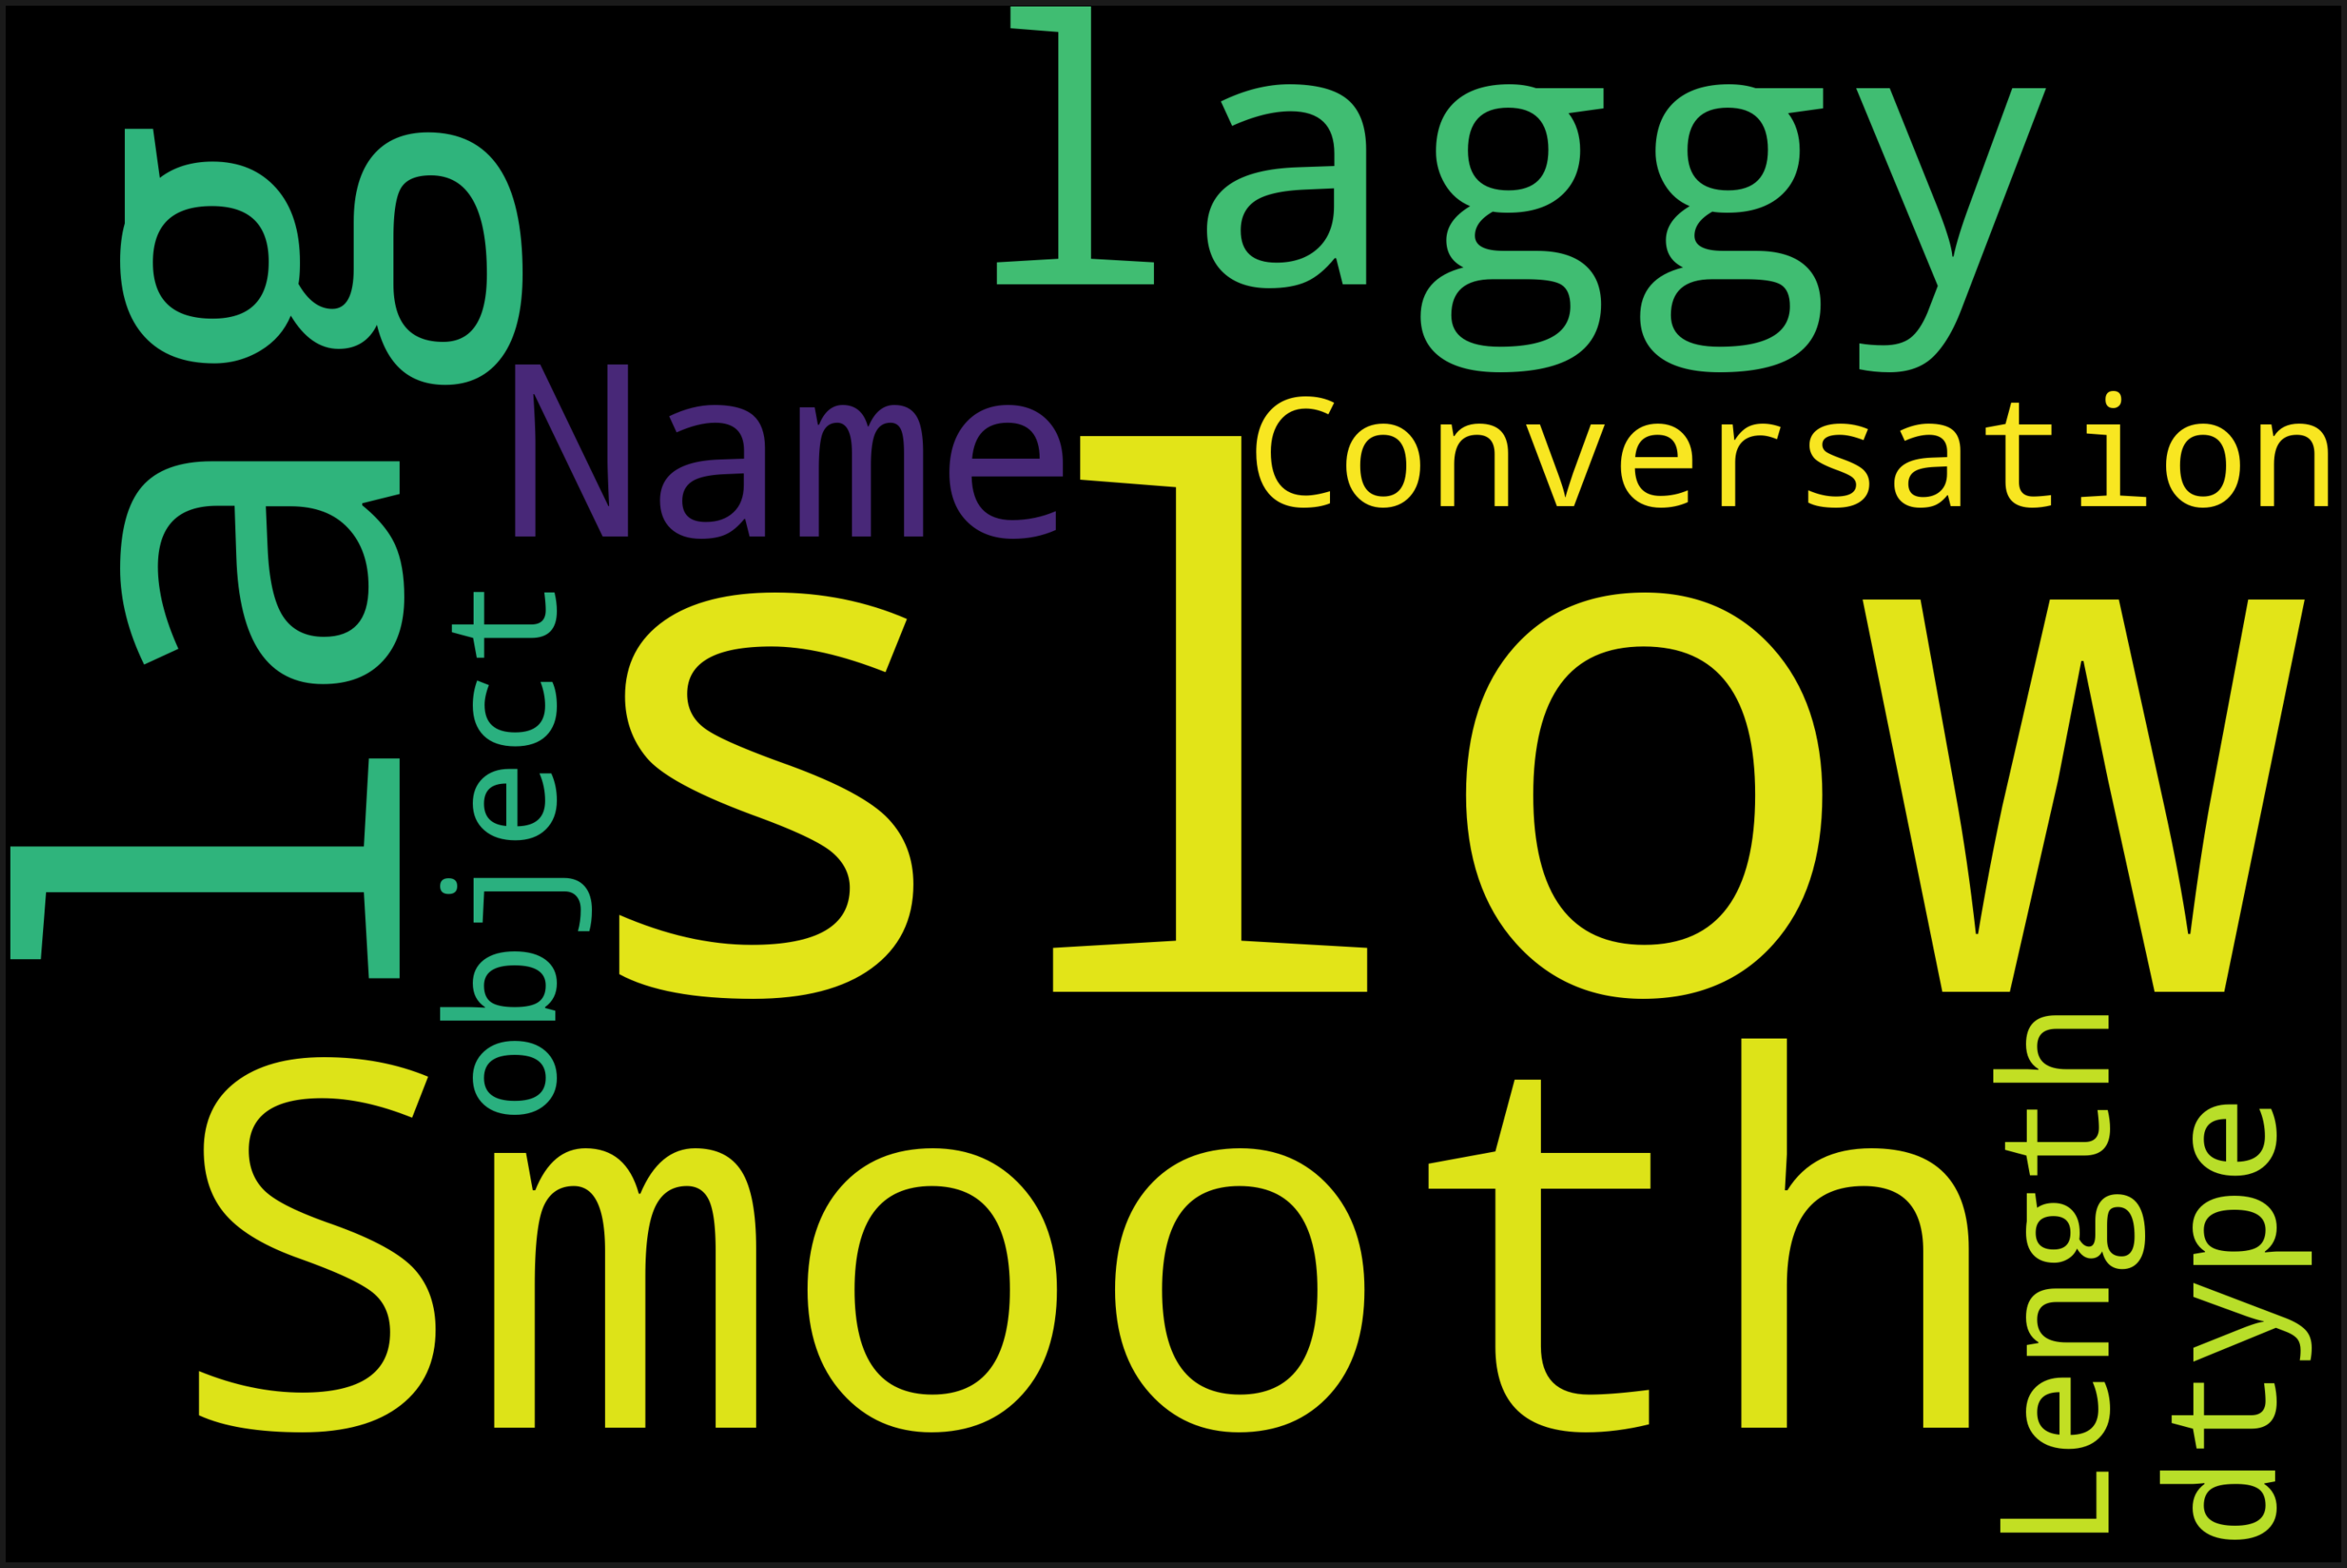

In [67]:
#Wordcloud of the category "Satisfied users" for comments with one token
topics = ["Satisfied users","Dissatisfied users","Design & UX","Performance"]

for topic in topics:
    data_containing_topic = rows_with_one_token_df.loc[rows_with_one_token_df[topic] == 1]

    text = data_containing_topic.Conversation
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')

    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.subplot()from scipy import stats

### Correlation between stars given and topic

In [104]:
from scipy import stats

#Correlation between rating and topic
for topic in topic_counts.index:
    correlation = complete_data_df["Rating"].corr(complete_data_df[topic])
    correlation_degree = ""
    if abs(correlation) > 0.5:
        correlation_degree = "high"
    elif abs(correlation) > 0.3:
        correlation_degree = "medium"
    else:
        correlation_degree = "low"
    print(f"correlation degree: {correlation_degree}({correlation}), topic: {topic}")

#The rating given by the user has correlation with the topics: Satisfied users, Dissatisfied users and Bugs. There is no correlation for the other topics

correlation degree: medium(0.48975411547671904), topic: Satisfied users
correlation degree: low(-0.047704205930427575), topic: Design & UX
correlation degree: low(0.08361638453883688), topic: Complexity
correlation degree: medium(-0.39642197641047433), topic: Dissatisfied users
correlation degree: low(-0.014061688570191714), topic: Gaming
correlation degree: low(0.058492077389707596), topic: Use cases
correlation degree: low(-0.1422913253456394), topic: Advertising
correlation degree: medium(-0.31207348454308903), topic: Bugs
correlation degree: low(-0.14426823355590074), topic: Performance
correlation degree: low(-0.11469293698082911), topic: Update
correlation degree: low(-0.09013436341375262), topic: Customer Support
correlation degree: low(-0.03416371115786233), topic: Camera & Photos
correlation degree: low(-0.10878285213584216), topic: Pricing
correlation degree: low(-0.13201854495212154), topic: Security & Accounts
correlation degree: low(-0.10182170827852843), topic: Notificati